## Importing

In [1]:
import cv2
import numpy as np
from os.path import join
#import pytesseract as ta
import matplotlib.pyplot as plt
import pandas as pd

## Reading and resizing

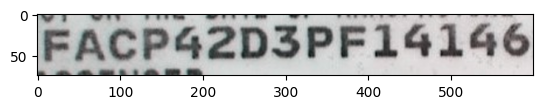

In [2]:
img = cv2.imread(r'./vinscanner/data/12-test.jpg')

#resizing
h, w, c = img.shape
ar = w/h
targetWidth = 600
targetHeight = int(targetWidth / ar)
img = cv2.resize(img, (targetWidth, targetHeight), interpolation=cv2.INTER_CUBIC)

plt.imshow(img);

## Preprocessing

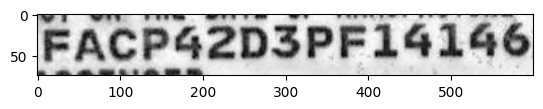

In [3]:
# blurring and splitting
img_blf = cv2.bilateralFilter(img, 5, 7,7)

lab = cv2.cvtColor(img_blf, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)

#clahe
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 4))
cl = clahe.apply(l)
limg = cv2.merge((cl, a, b))

# colour conversion
cimg = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
gray = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray');

## Determining background color

In [4]:
def check_bg_color(image):
    ''' Checks if background color is black or white '''
    check = cv2.threshold(image, 0,255, cv2.THRESH_OTSU)[1]
    print(check)
    u, c = np.unique(check, return_counts=True)
    d = dict(zip(u,c))
    print(d)
    srt = sorted(d.items(), key = lambda x : x[1], reverse = True)
    print(srt)
    return srt[0][0]

#checking color - if white then 255 else 0
bg_color = check_bg_color(gray)
print()
bg_color

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
{0: 13493, 255: 30907}
[(255, 30907), (0, 13493)]



255

## Check background color

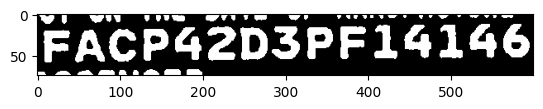

In [5]:
if bg_color == 255:
    ''' Performs preprocessing suitable for a white bg image '''
    ret4, final_img2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morp = cv2.morphologyEx(final_img2, cv2.MORPH_OPEN, (5,5))
    plt.imshow(morp, cmap='gray')
    
    
elif bg_color == 0:
    ''' Performs preprocessing suitable for a black bg image '''
    ret4, final_img2 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    morp = cv2.morphologyEx(final_img2, cv2.MORPH_OPEN, (5,5))
    plt.imshow(morp, cmap='gray')

## Horizontal projections

In [6]:
im = morp.copy()
    
horizontal_hist = np.sum(im, axis=1, keepdims=True)/255
v=horizontal_hist.flatten()
v

array([262., 262., 260., 253., 246., 209., 156., 122.,  91.,  57.,  29.,
        14.,   8.,  21.,  58.,  71., 132., 192., 222., 256., 276., 312.,
       307., 309., 304., 294., 283., 272., 265., 264., 245., 250., 265.,
       258., 292., 290., 304., 312., 321., 317., 315., 298., 283., 278.,
       275., 279., 267., 293., 290., 286., 276., 267., 251., 200., 151.,
       100.,  49.,  33.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,  34.,  72.,  97., 125., 133., 139., 144.])

In [7]:
df = pd.DataFrame(v)
df = df.T
df

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,262.0,262.0,260.0,253.0,246.0,209.0,156.0,122.0,91.0,57.0,...,0.0,0.0,0.0,34.0,72.0,97.0,125.0,133.0,139.0,144.0


## Plotting Horizontal histogram

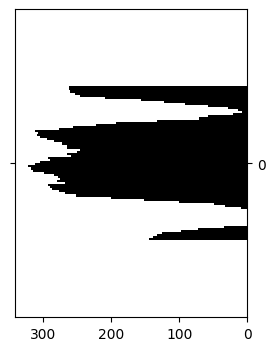

In [8]:
df.plot(kind='barh', color='k', legend=False, figsize=(3,4))
#plt.yticks.set_ticks_position("right")
plt.tick_params(axis='y', which='both', labelright=True, right=True, labelleft=False)
                                    #labelbottom = True, bottom = True, left=False

u = np.max(df.values) + 20
plt.xlim(u,0)
plt.gca().invert_yaxis()

plt.show()

## Dividing list into 2

In [9]:
ht = list(v)
print(len(ht))
half = len(ht)//2
print(half)

74
37


In [10]:
ht1 = ht[:half]
ht2 = ht[half:]

print(len(ht1))
print(len(ht2))

37
37


## Searching horizonal segments using threshold

In [11]:
threshold = 40  # threshold for extreme pixels of numbers (start and end of dips)
offset = len(ht1)

position will be x+len(ht1)

In [12]:
print(ht1)

[262.0, 262.0, 260.0, 253.0, 246.0, 209.0, 156.0, 122.0, 91.0, 57.0, 29.0, 14.0, 8.0, 21.0, 58.0, 71.0, 132.0, 192.0, 222.0, 256.0, 276.0, 312.0, 307.0, 309.0, 304.0, 294.0, 283.0, 272.0, 265.0, 264.0, 245.0, 250.0, 265.0, 258.0, 292.0, 290.0, 304.0]


## Searching dip center to top

In [13]:
for i in range(len(ht1)-1, -1, -1):
    print(ht1[i])
    
    #checking if value is < 40 and stopping
    if ht1[i] < 40:
        print('break point', i)
        left_limit = i+1
        print(left_limit)
        break

304.0
290.0
292.0
258.0
265.0
250.0
245.0
264.0
265.0
272.0
283.0
294.0
304.0
309.0
307.0
312.0
276.0
256.0
222.0
192.0
132.0
71.0
58.0
21.0
break point 13
14


In [14]:
print(ht2)

[312.0, 321.0, 317.0, 315.0, 298.0, 283.0, 278.0, 275.0, 279.0, 267.0, 293.0, 290.0, 286.0, 276.0, 267.0, 251.0, 200.0, 151.0, 100.0, 49.0, 33.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 72.0, 97.0, 125.0, 133.0, 139.0, 144.0]


## Searching dip center to bottom

In [15]:
for i in range(len(ht2)):
    print(ht2[i])
    
    if ht2[i] < threshold:
        print('break point', i)
        right_limit = i-1+offset
        print(right_limit)
        break

312.0
321.0
317.0
315.0
298.0
283.0
278.0
275.0
279.0
267.0
293.0
290.0
286.0
276.0
267.0
251.0
200.0
151.0
100.0
49.0
33.0
break point 20
56


In [16]:
print('Upper limit: ', left_limit)
print('Lower limit: ', right_limit)

Upper limit:  14
Lower limit:  56


## RoI

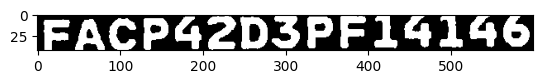

In [17]:
morp2 = morp[left_limit:right_limit+1]
plt.imshow(morp2, cmap='gray');

## Vertical projections

In [18]:
im = morp2.copy()
    
horizontal_hist = np.sum(im, axis=0, keepdims=True)/255
v=horizontal_hist.flatten()

df = pd.DataFrame(v)
df = df.T
df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,36.0,...,22.0,20.0,18.0,16.0,12.0,7.0,0.0,0.0,0.0,0.0


## Plotting Vertical histogram

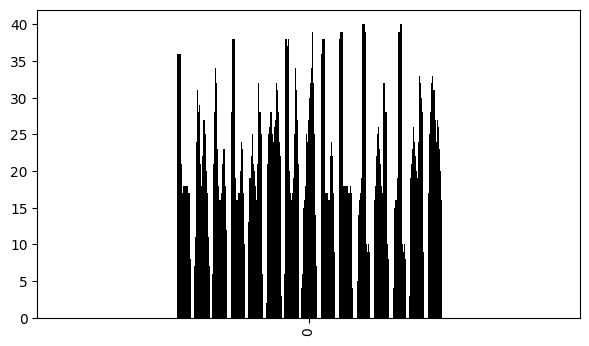

In [19]:
df.plot(kind='bar', color='k', legend=False, figsize=(7,4));

## Searching Vertical segments using threshold

In [20]:
check_left = []
check_right = []

In [21]:
pix_thresh = 3
width = 3

In [22]:
def strt(stat_index, arr):
    #print('starting with index:', stat_index)
    
    #finding start
    for i in range(stat_index, len(arr)):
        
        if arr[i] > pix_thresh:
            ##print('a > {}: {}'.format(pix_thresh, i))

            # finding the end
            for j in range(i+1,len(arr)):  # if i is >= len(arr) then this won't execute
                #print('j check:', j)
                if arr[j] < pix_thresh:
                    ##print('b < {}: {}'.format(pix_thresh, j))

                    # width check
                    if j - i > width:
                        #print('saving')
                        #saving if width is fine
                        check_left.append(i)
                        check_right.append(j)

                        # if we have reached the end, then exit
                        if i == len(arr)-1 or j == len(arr)-1:
                            #print('1st tick')
                            return
                            
                        # find a new start from after the pixel
                        else:
                            j = j+1
                            strt(j, arr) 
                            return

                    elif i == len(arr)-1 or j == len(arr)-1:
                            #print('2nd tick')
                            return
                        
                    else:
                        #print('Width is too less')
                        strt(j,arr)  # should be one elif
                        return
                
                
                #print('pixel', i, j) 
                if i == len(arr)-1 or j == len(arr)-1:
                    #print('3rd tick')
                    return
                

In [23]:
strt(0,v)

In [24]:
pairs = list(zip(check_left, check_right))
print(len(pairs), len(check_left), len(check_right))

15 15 15


In [25]:
pairs

[(8, 39),
 (46, 82),
 (87, 120),
 (129, 159),
 (167, 199),
 (207, 241),
 (246, 279),
 (284, 318),
 (327, 358),
 (367, 398),
 (408, 436),
 (445, 477),
 (487, 515),
 (524, 556),
 (564, 596)]

In [26]:
#morp3 = gray[left_limit:right_limit+1,:]

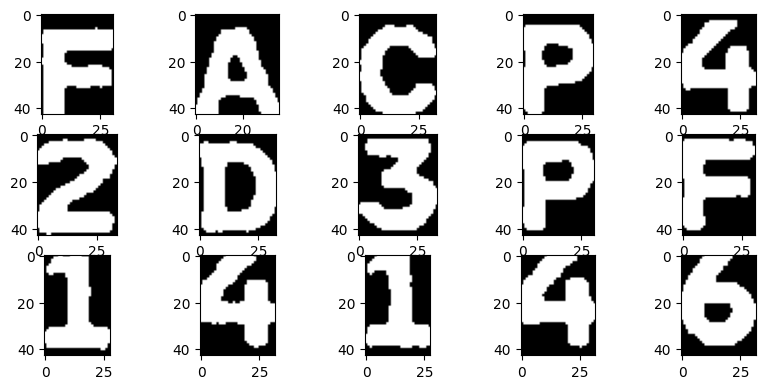

In [27]:
plt.figure(figsize=(10,6))
for i in range(len(pairs)):
    plt.subplot(4,5,i+1)
    plt.imshow(morp2[:, pairs[i][0]:pairs[i][1]], cmap='gray')

------

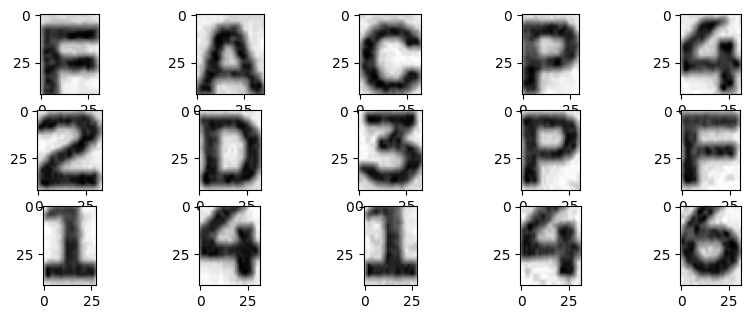

In [28]:
morp3 = gray[left_limit:right_limit]

plt.figure(figsize=(10,6))
for i in range(len(pairs)):
    plt.subplot(5,5,i+1)
    plt.imshow(morp3[:, pairs[i][0]:pairs[i][1]], cmap='gray')